In [1]:
%matplotlib inline
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import typhon as ty

import konrad

/home/mpim/m300580/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class RRTMGVenus(konrad.radiation.RRTMG):
    """Simple representation of radiative transfer on Venus.
    
    For the longwave radiation, the RRTMG simulations are used.
    The shortwave radiation is represented using
    a simple mathematical formulation.
    """
    def derive_diagnostics(self):
        """Derive diagnostic variables from radiative transfer results."""
        def solar_flux(p, k=10, S0=self.solar_constant):
            return S0 * np.exp(-k * p / p[0])

        def heating_rates(p, **kwargs):
            g = 10
            cp = 850
            secs_in_a_day = 60 * 60 * 24

            F = solar_flux(p, **kwargs)

            return g / cp * -np.diff(F) / np.diff(p) * secs_in_a_day

        sw_flxd = solar_flux(self['phlev'])
        Q_sw = heating_rates(self['phlev'])

        self['sw_htngrt'][-1, :] = Q_sw
        self['sw_flxd'][-1, :] = sw_flxd
        self['sw_flxu'][-1, :] = np.zeros_like(sw_flxd)

        # Net heating rate.
        self['net_htngrt'] = self['lw_htngrt'] + self['sw_htngrt']

        # Radiation budget at top of the atmosphere (TOA).
        self['toa'] = (
                (self['sw_flxd'][:, -1] + self['lw_flxd'][:, -1]) -
                (self['sw_flxu'][:, -1] + self['lw_flxu'][:, -1])
        )


# Create an atmosphere model.
atmosphere = konrad.atmosphere.Atmosphere.from_netcdf(
    ncfile='./data/tropical-standard.nc',
)

# Atmosphere composition corresponding to Venus.
for var in atmosphere.atmosphere_variables:
    if var != 'T':
        atmosphere[var][:] = 0
atmosphere['CO2'][:] = 0.999

# Compile the RCE setup.
rce = konrad.RCE(
    atmosphere=atmosphere,
    humidity=konrad.humidity.FixedVMR(),
    radiation=RRTMGVenus(solar_constant=170, zenith_angle=0),
    surface=konrad.surface.SurfaceHeatCapacity(albedo=0.7, depth=1.),
    convection=konrad.convection.NonConvective(),
    cloud=konrad.cloud.ClearSky(numlevels=atmosphere['plev'].size),
    delta=0,
    timestep='2h',
    max_duration='400d',
)
rce.run()  # Start the simulation.

2019-04-03 10:28:34 MainProcess:INFO:root:Created Konrad object:
RCE(
    atmosphere=Atmosphere,
    radiation=RRTMGVenus,
    ozone=OzonePressure,
    humidity=FixedVMR,
    surface=SurfaceHeatCapacity,
    cloud=<konrad.cloud.ClearSky object at 0x7f3af3942240>,
    convection=NonConvective,
    lapserate=MoistLapseRate,
    upwelling=NoUpwelling,
    max_duration=400.0,
    timestep=0.08333333333333333,
    writeevery=1.0,
    max_iterations=4800.0,
    niter=0,
    delta=0,
    deltaT=None,
    converged=False,
    outfile=None,
    nchandler=None,
    experiment=RCE,
)
2019-04-03 10:28:34 MainProcess:INFO:konrad.core:Start RCE model run.
2019-04-03 10:28:34 MainProcess:INFO:konrad.core:Enter iteration 0.
2019-04-03 10:28:35 MainProcess:INFO:konrad.core:Enter iteration 100.
2019-04-03 10:28:37 MainProcess:INFO:konrad.core:Enter iteration 200.
2019-04-03 10:28:38 MainProcess:INFO:konrad.core:Enter iteration 300.
2019-04-03 10:28:40 MainProcess:INFO:konrad.core:Enter iteration 400.
20

(101300.0, 5.0)

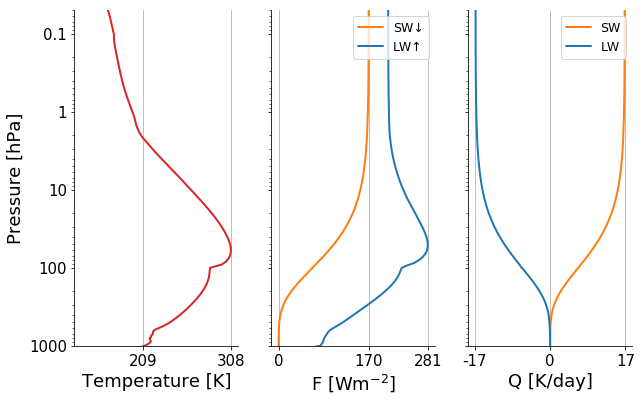

In [3]:
plev = rce.atmosphere['plev'][:]
phlev = rce.atmosphere['phlev'][:]
T = rce.atmosphere['T'][-1, :]
sw_htngrt = rce.radiation['sw_htngrt'][-1, :]
lw_htngrt = rce.radiation['lw_htngrt'][-1, :]
sw_flxd = rce.radiation['sw_flxd'][-1, :]
lw_flxu = rce.radiation['lw_flxu'][-1, :]
    
plt.style.use(ty.plots.styles('typhon'))
fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, sharey=True)
ty.plots.profile_p_log(plev, T, ax=ax0, color='C3')
ax0.set_ylim(plev.max(), plev.min())
ax0.set_xlabel('Temperature [K]')
ax0.set_xticks(np.round([T.max(), T[0]]))
ax0.grid(True, axis='x')

ty.plots.profile_p_log(phlev, sw_flxd, color='C1', label='SW↓', ax=ax1)
ty.plots.profile_p_log(phlev, lw_flxu, color='C0', label='LW↑', ax=ax1)
ax1.legend(loc='upper right', fontsize='x-small')
ax1.set_ylim(plev.max(), plev.min())
ax1.set_xlabel('F [$\sf Wm^{-2}$]')
ax1.set_xticks(np.round([0, sw_flxd.max(), lw_flxu.max()]))
ax1.grid(True, axis='x')

ty.plots.profile_p_log(plev, sw_htngrt, color='C1', label='SW', ax=ax2)
ty.plots.profile_p_log(plev, lw_htngrt, color='C0', label='LW', ax=ax2)
ax2.legend(loc='upper right', fontsize='x-small')
ax2.set_ylim(plev.max(), plev.min())
ax2.set_xlabel('Q [K/day]')
ax2.set_xticks(np.round([0, sw_htngrt.max(), lw_htngrt.min()]))
ax2.grid(True, axis='x')
ax2.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))

ax2.set_ylim(top=0.05e2)